In [33]:
from scipy import optimize
import sympy as sym
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np

In [34]:
class Task:
    def __init__(self, A, a1, a2, w1, w2, I, x0=0, y0=0):
        self.Q = "A * x ** a_1 * y ** a_2"
        self.A = A
        self.a1 = a1
        self.a2 = a2
        self.w1 = w1
        self.w2 = w2
        self.I = I
        self.x0 = x0
        self.y0 = y0
        self.sym_Q = sym.parse_expr(self.Q)
        self.sym_U = (self.sym_Q + sym.parse_expr("- w_1 * x - w_2 * y"))\
            .subs(dict(A=self.A,
                       a_1=self.a1,
                       a_2=self.a2,
                       w_1=self.w1,
                       w_2=self.w2))

        self.lambd_U = sym.lambdify(['x', 'y'], self.sym_U)
        self.constraints = [{'type': 'ineq', 'fun': lambda x: I - w1 * x[0] - w2 * x[1]}]
        self.max_x, \
        self.max_y, \
        self.max_U = self.find_max()
        self.plots_data = {
            'x': np.linspace(1, 100, 100),
            'y': np.linspace(1, 100, 100),
        }
        self.plots_data['z'] = np.vectorize(self.lambd_U)(*np.meshgrid(self.plots_data['x'], self.plots_data['y']))
        self.surface_plot, \
        self.contour_plot = self._get_plots()


    def find_max(self):
        res = optimize.minimize(lambda x: -self.lambd_U(x[0], x[1]), (self.x0, self.y0), constraints=self.constraints)
        return res.x[0], res.x[1], -res.fun


    def _get_plots(self):
            scene = go.Scene(
            xaxis = {'title': 'Кол-во ресурсов 1'},
            yaxis = {'title': 'Кол-во ресурсов 2'},
            zaxis = {'title': 'Прибыль'})
            layout = go.Layout(title="График функции прибыли",scene=scene)

            return self._get_surface_plot(layout), lambda : self._get_contour_plot()


    def _get_contour_plot(self):
        fig, ax = plt.subplots()
        contour = ax.contour(*self.plots_data.values(),levels = (90,110, 130, 140, self.max_U), colors = ("darkblue", "grey", "yellow", "green", "red"))
        ax.clabel(contour, inline=True, fontsize=15)
        x = np.linspace(2, (self.I/self.w1))
        y_tre = (self.I - self.w1 * x) / self.w2
        y_2 = 0
        fig2 = ax.fill_between(x, y_2, y_tre)
        fig2.set_facecolor('blue')
        fig.set_figwidth(15)
        fig.set_figheight(15)
        plt.title("Изокванты")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.plot(self.max_x, self.max_y, marker="o", markersize=5, markeredgecolor="red", markerfacecolor="red")
        plt.text(self.max_x - 3,self.max_y - 2,f'M*{round(self.max_x), round(self.max_y)}',horizontalalignment='right', color="red")
        res2 = optimize.minimize(lambda x: -self.lambd_U(x[0], x[1]), x0=(self.x0,self.y0), method="BFGS")
        bfgs_x, bfgs_y = res2.x[0], res2.x[1]
        plt.plot(bfgs_x, bfgs_y, marker="o", markersize=5, markeredgecolor="red", markerfacecolor="black")
        plt.text(bfgs_x + 10,bfgs_y + 4,f'{round(-res2["fun"])}',horizontalalignment='right', color="black", fontsize=12)


    def _get_surface_plot(self, layout):
        surf = go.Surface(**self.plots_data)
        scatter_3d = go.Scatter3d(
                          x=[self.max_x],
                          y=[self.max_y],
                          z=[self.max_U],
                          mode="markers+text",
                          text=[f'M* ({self.max_x},{self.max_y})']
                          )
        fig = go.Figure(data=[surf, scatter_3d], layout=layout)
        return fig


    def __repr__(self):
        return f'Ответ. M* ({self.max_x, self.max_y}); U(M*) = {self.max_U}'

In [35]:
A = 30
a1 = 1/2
a2 = 0.2
w1 = 4
w2 = 2
I = 120

res = Task(A, a1, a2, w1, w2, I, 5, 5)
res

Ответ. M* ((21.42857825622538, 17.142843487548834)); U(M*) = 125.15147208865139

In [36]:
res.surface_plot

ValueError: Contour levels must be increasing

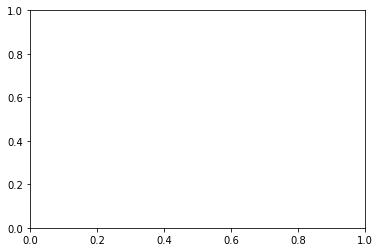

In [37]:
#Должно работать, но вылезает ошибка
res.contour_plot()